In [1]:
import glob
from astropy.table import Table
import fitsio
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from scipy import stats
import pandas as pd

In [2]:
def process_fits_file(fafn):
    tile_data = {}
    _, h = fitsio.read(fafn, "PRIMARY", header=True)
    
    try:
        program = h["FAPRGRM"]
    except KeyError:
        program = "undefined"
        print('failed FAPRGM using undefined', fafn)
        #return None
        
    try:
        date_string = h["NOWTIME"]
    except KeyError:
        print('failed NOW TIME, using FA_RUN', fafn)
        date_string = h["FA_RUN"]
        #return None
    
    tile_data["program"] = program
    tile_data["ra"] = h["TILERA"]
    tile_data["dec"] = h["TILEDEC"]
    
    try:
        datetime_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S%z').replace(tzinfo=pytz.UTC)
    except:
        datetime_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=pytz.UTC)
        
    print(datetime_obj)
    reference_date = datetime(2021, 5, 14, tzinfo=pytz.UTC) # The start of the main survey
    days_difference = (datetime_obj - reference_date).total_seconds()/(24.0*3600.0)
    tile_data["days_difference"] = days_difference
    
    d = Table(fitsio.read(fafn, "FIBERASSIGN"))

    sky = d["OBJTYPE"] == "SKY"
    good_fibers = d["FIBERSTATUS"]==0 
    expid_str = fafn.split(os.path.sep)[-2]
    
    try:
        tile_data["nsecondary"] = np.count_nonzero(d['SCND_TARGET']!=0)
    except:
        tile_data["nsecondary"] = 0
    
    tile_data["nsky"] = np.count_nonzero(sky)
    tile_data["nskygoodfiber"] = np.count_nonzero(sky&good_fibers)
    tile_data["nskybadfiber"] = np.count_nonzero(sky&(~good_fibers))
    tile_data["expid"] = int(expid_str)
    tile_data["nlowp"] = np.count_nonzero((d["PRIORITY"]<1400) & (d["OBJTYPE"]=="TGT"))
    tile_data["nverylowp"] = np.count_nonzero((d["PRIORITY"]<100) & (d["OBJTYPE"]=="TGT"))
    
    return tile_data

def process_fits_files(fafns):
    tile_nsky = []
    tile_nsky_goodfiber = []
    tile_nsky_badfiber = []
    tile_nlowp = []
    tile_nverylowp = []
    expid = []
    tile_program = []
    tile_ra = []
    tile_dec = []
    tile_days = []
    tile_nsecondary = []
    

    for fafn in fafns:
        tile_data = process_fits_file(fafn)
        if tile_data:
            tile_program.append(tile_data["program"])
            tile_ra.append(tile_data["ra"])
            tile_dec.append(tile_data["dec"])
            tile_days.append(tile_data["days_difference"])
            tile_nsky.append(tile_data["nsky"])
            tile_nsky_goodfiber.append(tile_data["nskygoodfiber"])
            tile_nsky_badfiber.append(tile_data["nskybadfiber"])
            tile_nlowp.append(tile_data["nlowp"])
            tile_nverylowp.append(tile_data["nverylowp"])
            tile_nsecondary.append(tile_data["nsecondary"])
            expid.append(tile_data["expid"])
            
    data = {"tile_nsky": np.array(tile_nsky),
            "tile_nsky_goodfiber":np.array(tile_nsky_goodfiber),
            "tile_nsky_badfiber":np.array(tile_nsky_badfiber),
            "tile_nlowp":np.array(tile_nlowp),
            "tile_nverylowp":np.array(tile_nverylowp),
            "expid": np.array(expid),
            "tile_program": np.array(tile_program),
            "tile_ra": np.array(tile_ra),
            "tile_dec": np.array(tile_dec),
            "tile_days": np.array(tile_days),
            "tile_nsecondary":np.array(tile_nsecondary)
    }
    df = pd.DataFrame(data)
    return df

def process_year(year):
    fafns = sorted(glob.glob("/global/cfs/cdirs/desi/spectro/data/{}*/????????/fiberassign*fits.gz".format(year)))
    print('gathered {} files'.format(len(fafns)))
    df_year = process_fits_files(fafns)
    filename = '{}_nsky_lowp_data.csv'.format(year)
    df_year.to_csv(filename, index=False)

In [38]:
#fafns = sorted(glob.glob("/global/cfs/cdirs/desi/spectro/data/{}*/????????/fiberassign*fits.gz".format(2024)))

In [49]:
#d = Table(fitsio.read(fafns[1], "FIBERASSIGN"))
#is_second = d['SCND_TARGET']!=0
#is_lowp = d['PRIORITY']<100

In [50]:
#set(d['OBJTYPE'][is_second]), set(d['OBJTYPE'][is_lowp])

({'TGT'}, {'', 'SKY', 'TGT'})

In [3]:
#for year in [2021, 2022, 2023, 2024]:
#    process_year(year)

In [4]:
data_A = pd.read_csv('2021_nsky_lowp_data.csv')
data_B = pd.read_csv('2022_nsky_lowp_data.csv')
data_C = pd.read_csv('2023_nsky_lowp_data.csv')
data_D = pd.read_csv('2024_nsky_lowp_data.csv')

In [5]:
data = pd.concat([data_A, data_B, data_C, data_D], axis=0, ignore_index=True)

In [45]:
def plot_quantity(data, col_name='tile_nsky', col_label='number of sky fibers', ylim=[400,1000]):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)

    plt.title('Dark')
    ii = (data['tile_program']=='dark') #& (data['day']>600)
    dark_time = np.array(data['tile_days'][ii]/365.0)
    dark_counts = np.array(data[col_name][ii])
    ll = np.argsort(dark_time)
    dark_time = dark_time[ll]
    dark_counts = dark_counts[ll]
    
    plt.scatter(dark_time, dark_counts, alpha=0.1)

    plt.ylabel(col_label)
    plt.xlabel("Years since survey started")
    plt.ylim(ylim)
    plt.xlim(0., 3)


    slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data[col_name][ii])
    x = np.sort(data['tile_days'][ii])
    plt.plot(x/365., slope*x + intercept, color='red')
    print(slope)

    plt.subplot(1,3,2)
    plt.title('Bright')
    ii = (data['tile_program']=='bright') #& (data['day']>600)
    bright_time = np.array(data['tile_days'][ii]/365.0)
    bright_counts = np.array(data[col_name][ii])
    ll = np.argsort(bright_time)
    bright_time = bright_time[ll]
    bright_counts = bright_counts[ll]    
    
    plt.scatter(bright_time, bright_counts, alpha=0.1)

    plt.xlabel("Years since survey started")
    plt.ylim(ylim)
    plt.xlim(0., 3.)

    slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data[col_name][ii])
    x = np.sort(data['tile_days'][ii])
    plt.plot(x/365., slope*x + intercept, color='red')
    print(slope)

    
    plt.subplot(1,3,3)
    plt.plot(dark_time, np.cumsum(dark_counts), label='dark')

    plt.plot(bright_time, np.cumsum(bright_counts), label='bright')
    

    plt.xlabel("Years since survey started")
    plt.ylabel("Cumulative "+col_label)
    plt.xlim(0., 3.)
    plt.legend()
    plt.grid()
    plt.savefig(col_name+'.jpg')

0.06447718162876306
0.12963004820469698


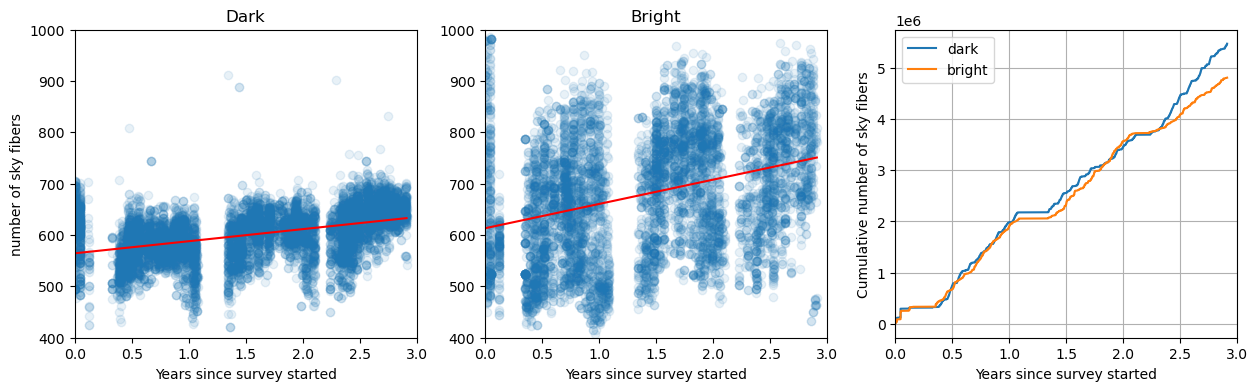

In [46]:
plot_quantity(data, col_name='tile_nsky', col_label='number of sky fibers')

0.3542753230523088
0.47662916895187973


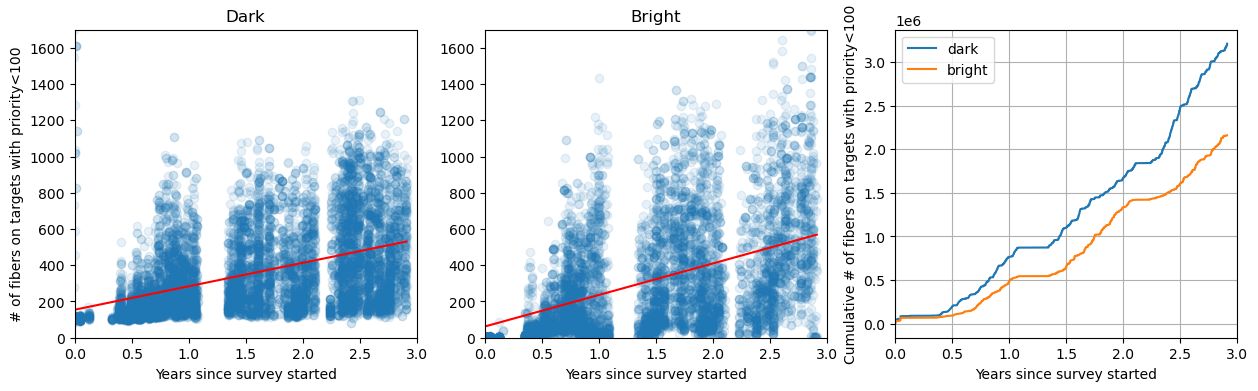

In [47]:
plot_quantity(data, col_name='tile_nverylowp', col_label='# of fibers on targets with priority<100', ylim=[0,1700])

-0.16793827288427174
0.0538236811443007


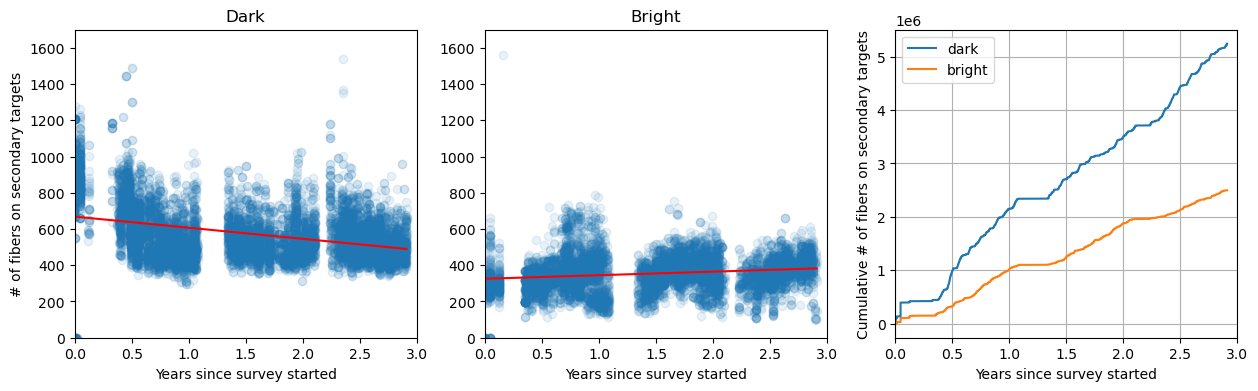

In [48]:
plot_quantity(data, col_name='tile_nsecondary', col_label='# of fibers on secondary targets', ylim=[0,1700])